In [1]:
from Brainmets.utils import *
from Brainmets.dataset import *
from Brainmets.augmentations import Transformer
from Brainmets.losses import *
from Brainmets.trainer import *
from Brainmets.evaluation import *

Using TensorFlow backend.


In [3]:
device = torch.device('cuda: 1')
model = ResidualUNet3D(1, 1, True).to(device)
model_name = 'nearest/Baseline-Diceloss-test_3-0.001/epoch_38_val_score=0.7961517106553521.pth'
state_dict = torch.load(model_name)

[16, 32, 64, 128, 256, 512]


In [ ]:
model.load_state_dict(state_dict)

In [3]:
data_path = Path('/home/chens/practicum/MEDomicsLab-develop-brainmets/model_training/3_unet_3d_residual/data/')
data = 'manuscript_1_datasets_first_tx_allmets'
df = pd.read_csv(data_path/f'{data}.csv')

In [21]:
train_df = df[df['split'] == 'train'].sample(frac=1)
valid_df = df[df['split'] == 'valid'].sample(frac=1)
test_df = df[df['split'] == 'test'].sample(frac=1)

train_img_files = list(train_df['img_files'])
train_mask_files = list(train_df['mask_files'])
valid_img_files = list(valid_df['img_files'])
valid_mask_files = list(valid_df['mask_files'])
test_img_files = list(test_df['img_files'])
test_mask_files = list(test_df['mask_files'])

# train_dataset = MetDataSet(train_df)
# valid_dataset = MetDataSet(valid_df)
# test_dataset = MetDataSet(test_df)

In [4]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)

In [ ]:
metrics = compute_per_channel_dice
model.eval()
total_test_loss = 0
total_test_score = 0
for index, test_batch in tqdm(
    enumerate(
        test_loader), total=len(
        test_loader)):
    test_sample_img, test_sample_mask = test_batch
    test_sample_img = test_sample_img.to(device).float()
    test_sample_mask = test_sample_mask.to(device).float()
    del test_batch
    gc.collect()
    with torch.no_grad():
        test_predicted_mask = model(test_sample_img)
    test_score = metrics(test_predicted_mask, test_sample_mask)
    total_test_score += test_score.item()
    del test_sample_img, test_sample_mask, test_predicted_mask, test_score
    gc.collect()
print('test_score: ' + str(total_test_score / len(test_dataset)))
torch.cuda.empty_cache()
test_score = total_test_score / len(test_dataset)

In [5]:
mask = test_dataset[0][1][0]

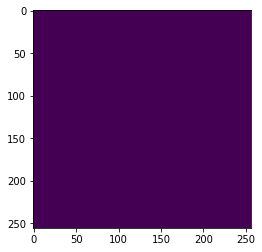

In [6]:
plt.imshow(mask[44])

In [22]:
from scipy import ndimage

In [23]:
def met_volume(image,res):
    numMets = np.amax(image)# max number
    metNum, counts = np.unique(image.flatten(), return_counts=True)
    return np.asarray(counts[1:]*res)

In [26]:
def size_filter(mask, size, return_volumes=False):
    new_mask = ndimage.label(mask)[0]
    volumes = met_volume(new_mask, 0.003)
    if return_volumes:
        return volumes
    index_to_keep = np.arange(1, len(volumes)+1)[np.logical_and(volumes>=size[0], volumes<=size[1])]
    for index in np.arange(1, len(volumes)+1):
        if index not in index_to_keep:
            new_mask[new_mask==index] = 0
        else:
            new_mask[new_mask==index] = 1
    return new_mask

In [19]:
filtered_mask = size_filter(mask, [0.5,1])

[ 1.2   1.86  0.3   2.04  0.48  0.24  0.39  1.38  0.39  2.01  3.93 18.
 10.71  0.93  3.93  1.98]


In [20]:
met_volume(ndimage.label(filtered_mask)[0], 0.03)

array([0.93])

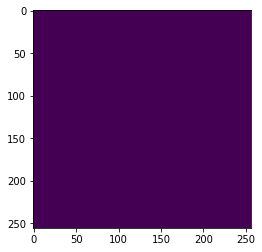

In [21]:
plt.imshow(filtered_mask[44])

In [61]:
def location_filter(mask, location, return_locations=False):
    new_mask = ndimage.label(mask)[0]
    labels = ndimage.label(mask)[0]
    index_to_keep = []
    if return_locations:
        locations = []
        for i in range(1, labels.max()+1):
            cm_i = ndimage.measurements.center_of_mass(mask, labels, i)
            if cm_i[0] >= 25 and cm_i[2] < 128 and cm_i[1] >= 150: # right front cortex
                locations.append('right_front')
            elif cm_i[0] >= 25 and cm_i[2] >= 128 and cm_i[1] >= 150: # left front cortex
                locations.append('left_front')
            elif cm_i[0] >= 25 and cm_i[2] < 128 and cm_i[1] < 150: # right pos cortex
                locations.append('right_pos')
            elif cm_i[0] >= 25 and cm_i[2] >= 128 and cm_i[1] < 150: # left pos cortex
                locations.append('left_pos')
            elif cm_i[0] < 25 and cm_i[2] < 128: # right cerebellum
                locations.append('right_cerebellum')
            elif cm_i[0] < 25 and cm_i[2] >= 128: # left cerebellum
                locations.append('left_cerebellum')
        return locations
    for i in range(1, labels.max()+1):
        cm_i = ndimage.measurements.center_of_mass(mask, labels, i)
        if ((location == 'right_front') and (cm_i[0] >= 25 and cm_i[2] < 128 and cm_i[1] >= 150)) or \
           ((location == 'left_front') and (cm_i[0] >= 25 and cm_i[2] >= 128 and cm_i[1] >= 150)) or \
           ((location == 'right_pos') and (cm_i[0] >= 25 and cm_i[2] < 128 and cm_i[1] < 150)) or \
           ((location == 'left_pos') and (cm_i[0] >= 25 and cm_i[2] >= 128 and cm_i[1] < 150)) or \
           ((location == 'right_cerebellum') and (cm_i[0] < 25 and cm_i[2] < 128)) or \
           ((location == 'left_cerebellum') and (cm_i[0] < 25 and cm_i[2] >= 128)):
            index_to_keep.append(i)
    for index in np.arange(1, len(labels)+1):
        if index not in index_to_keep:
            new_mask[new_mask==index] = 0
        else:
            new_mask[new_mask==index] = 1
    return new_mask

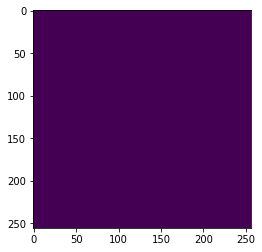

In [23]:
plt.imshow(location_filter(mask, 'right_front')[44])

In [62]:
class TestMetDataSet(Dataset):
    def __init__(self, df, number, size, location):

        self.size = size
        self.location = location
        if number:
            df = df[(df['met_num'] >= number[0]) & (df['met_num'] <= number[1])]
            
        self.img_files = list(df['img_files'])
        self.mask_files = list(df['mask_files'])
        self.img_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in self.img_files]
        self.mask_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in self.mask_files]
    def __len__(self):
        return len(self.img_files)
    def __getitem__(self, idx):
        img = read_and_crop(self.img_files[idx],64,256,256).reshape(1,64,256,256)
        mask = read_and_crop(self.mask_files[idx],64,256,256).reshape(1,64,256,256)
        if self.size:
            mask = size_filter(mask[0], self.size).reshape(1,64,256,256)
        if self.location:
            mask = location_filter(mask[0], self.location).reshape(1,64,256,256)
        return img.copy(), mask.copy()
    def get_name(self,idx):
        img_name = self.img_names[idx]
        mask_name = self.mask_names[idx]
        return img_name,mask_name
    def get_volumes(self, idx):
        img = read_and_crop(self.img_files[idx],64,256,256).reshape(1,64,256,256)
        mask = read_and_crop(self.mask_files[idx],64,256,256).reshape(1,64,256,256)
        volumes = size_filter(mask[0], self.size, return_volumes=True)
        return volumes
    def get_locations(self, idx):
        img = read_and_crop(self.img_files[idx],64,256,256).reshape(1,64,256,256)
        mask = read_and_crop(self.mask_files[idx],64,256,256).reshape(1,64,256,256)
        locations = location_filter(mask[0], self.location, return_locations=True)
        return locations

In [76]:
train_dataset = TestMetDataSet(train_df, None, [0,50000], None)
valid_dataset = TestMetDataSet(valid_df, None, [0,50000], None)
test_dataset = TestMetDataSet(test_df, None, [0,50000], None)

### Volume

In [107]:
volumes = []

In [103]:
for i in range(len(valid_dataset)):
    volumes.append(valid_dataset.get_volumes(i))

In [104]:
volumes = np.concatenate(volumes)

In [105]:
bins = [[0, 0.1], [0.1, 0.5], [0.5, 1], [1, 2], [2, 5], [5, np.inf]]

In [99]:
print('training dataset')
for size_bin in bins:
    print('size between {:.2f} and {:.2f}: {:4d}'.format(size_bin[0], size_bin[1], len(volumes[np.logical_and(volumes>=size_bin[0], volumes<size_bin[1])])))

training dataset
size between 0.00 and 0.10:  754
size between 0.10 and 0.50:  620
size between 0.50 and 1.00:  190
size between 1.00 and 2.00:  160
size between 2.00 and 5.00:  212
size between 5.00 and inf:  200


In [106]:
print('valid dataset')
for size_bin in bins:
    print('size between {:.2f} and {:.2f}: {:4d}'.format(size_bin[0], size_bin[1], len(volumes[np.logical_and(volumes>=size_bin[0], volumes<size_bin[1])])))

valid dataset
size between 0.00 and 0.10:  160
size between 0.10 and 0.50:  142
size between 0.50 and 1.00:   35
size between 1.00 and 2.00:   34
size between 2.00 and 5.00:   45
size between 5.00 and inf:   36


In [94]:
print('testing dataset')
for size_bin in bins:
    print('size between {:.2f} and {:.2f}: {:4d}'.format(size_bin[0], size_bin[1], len(volumes[np.logical_and(volumes>=size_bin[0], volumes<size_bin[1])])))

testing dataset
size between 0.00 and 0.10:  160
size between 0.10 and 0.50:  167
size between 0.50 and 1.00:   37
size between 1.00 and 2.00:   46
size between 2.00 and 5.00:   49
size between 5.00 and inf:   41


### Location

In [82]:
locations = []

In [83]:
for i in range(len(test_dataset)):
    locations.append(test_dataset.get_locations(i))

In [84]:
locations = np.concatenate(locations)

In [75]:
print('training dataset')
for location, num in zip(np.unique(locations, return_counts=True)[0], np.unique(locations, return_counts=True)[1]):
    print('{:20s}: {:3d}'.format(location, num))

training dataset
left_cerebellum     : 290
left_front          : 288
left_pos            : 471
right_cerebellum    : 267
right_front         : 304
right_pos           : 516


In [81]:
print('valid dataset')
for location, num in zip(np.unique(locations, return_counts=True)[0], np.unique(locations, return_counts=True)[1]):
    print('{:20s}: {:3d}'.format(location, num))

valid dataset
left_cerebellum     :  59
left_front          :  62
left_pos            : 103
right_cerebellum    :  61
right_front         :  61
right_pos           : 106


In [85]:
print('testing dataset')
for location, num in zip(np.unique(locations, return_counts=True)[0], np.unique(locations, return_counts=True)[1]):
    print('{:20s}: {:3d}'.format(location, num))

testing dataset
left_cerebellum     :  52
left_front          :  56
left_pos            : 128
right_cerebellum    :  78
right_front         :  68
right_pos           : 118


### Number

In [115]:
bins = [[1, 1], [2, 2], [3, 5], [6, 10], [11, np.inf]]

In [119]:
print('all dataset')
for size_bin in bins:
    print('size between {:.2f} and {:.2f}: {:4d}'.format(size_bin[0], size_bin[1], len(df['met_num'].values[np.logical_and(df['met_num'].values>=size_bin[0], df['met_num'].values<=size_bin[1])])))
        

all dataset
size between 1.00 and 1.00:  178
size between 2.00 and 2.00:  140
size between 3.00 and 5.00:  183
size between 6.00 and 10.00:  119
size between 11.00 and inf:   66


In [116]:
print('training dataset')
for size_bin in bins:
    print('size between {:.2f} and {:.2f}: {:4d}'.format(size_bin[0], size_bin[1], len(train_df['met_num'].values[np.logical_and(train_df['met_num'].values>=size_bin[0], train_df['met_num'].values<=size_bin[1])])))

training dataset
size between 1.00 and 1.00:  124
size between 2.00 and 2.00:   98
size between 3.00 and 5.00:  127
size between 6.00 and 10.00:   83
size between 11.00 and inf:   45


In [117]:
print('valid dataset')
for size_bin in bins:
    print('size between {:.2f} and {:.2f}: {:4d}'.format(size_bin[0], size_bin[1], len(valid_df['met_num'].values[np.logical_and(valid_df['met_num'].values>=size_bin[0], valid_df['met_num'].values<=size_bin[1])])))
    
    

valid dataset
size between 1.00 and 1.00:   26
size between 2.00 and 2.00:   20
size between 3.00 and 5.00:   26
size between 6.00 and 10.00:   17
size between 11.00 and inf:   10


In [118]:
print('testing dataset')
for size_bin in bins:
    print('size between {:.2f} and {:.2f}: {:4d}'.format(size_bin[0], size_bin[1], len(test_df['met_num'].values[np.logical_and(test_df['met_num'].values>=size_bin[0], test_df['met_num'].values<=size_bin[1])])))
    

testing dataset
size between 1.00 and 1.00:   28
size between 2.00 and 2.00:   22
size between 3.00 and 5.00:   30
size between 6.00 and 10.00:   19
size between 11.00 and inf:   11
